In [1]:
!pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-j06eexij
  Running command git clone -q https://github.com/fra31/auto-attack /tmp/pip-req-build-j06eexij
  Resolved https://github.com/fra31/auto-attack to commit aaba775aedf24c86099ca0340d62275878a101ae


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from autoattack.autopgd_base import APGDAttack
import seaborn as sns
plt.rcParams['text.usetex'] = True

In [3]:
sns.set_theme()

# Generating Gaussian Data

In [4]:
# condition gaussian parameters
def get_data(n, sigma, m=1000):
    theta_0 = torch.zeros(1, n, n)
    theta_0[0,0,0] = 0.25
    theta_1 = torch.zeros(1, n, n)
    theta_1[0,0,0] = 0.75
    
    class_0 = sigma * torch.randn(m, *theta_0.size()) + theta_0
    labels = torch.zeros(m)
    class_1 = sigma * torch.randn(m, *theta_1.size()) + theta_1
    labels1 = torch.ones(m)

    data_all = torch.cat([class_0, class_1])
    data_all = data_all.clamp(0, 1)
    labels_all = torch.cat([labels, labels1])
    permutation = torch.randperm(data_all.size()[0])
    data_all = data_all[permutation]
    labels_all = labels_all[permutation].long()
    return data_all, labels_all

# Model Definition, Training, and Evaluation Functions

In [5]:
class ToyNet(nn.Module):
    def __init__(self, n, d):
        super(ToyNet, self).__init__()
        self.h = nn.Linear(n * n, d)
        self.g = nn.Linear(d, 2, bias=False)
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        return self.g(self.h(x))
    def randomize_h(self):
        torch.nn.init.normal_(self.h.weight)
        torch.nn.init.normal_(self.h.bias)

In [6]:
criterion = nn.CrossEntropyLoss()

def train_varreg(model, epsilon, opt, norm, data_all, labels_all, reg=1, epochs = 200, verbose=False):
    if epsilon > 0:
        adversary = APGDAttack(model, norm=norm, eps=epsilon)
    model.train()
    for i in range(epochs):
        loss_total = 0
        for j in range(10):
            data = data_all[j*100: j*100+100, :,:, :]
            label = labels_all[j*100: j*100+100]
            if epsilon > 0:
                inputs = adversary.perturb(data, label)
            else:
                inputs = data
            output = model(inputs)
            loss = criterion(output, label)
            if reg > 0:
                x1, x2 = variation_single(data, model, epsilon, norm)
                loss += reg * torch.norm(model.h(x1)- model.h(x2), p=2, dim=-1).mean()
            loss_total += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        if verbose:
            print('epoch {}, loss {}'.format(i, loss_total))        

def val(model, epsilons, norm, data_all, labels_all):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction='sum')
    losses = []
    for epsilon in epsilons:
        if epsilon > 0:
            adversary = APGDAttack(model, norm=norm, eps=epsilon)
        loss_sum = 0
        data = data_all
        label = labels_all
        if epsilon > 0:
            inputs = adversary.perturb(data, label)
        else:
            inputs = data
        with torch.no_grad():
            output = model(inputs)
            loss = ce(output, label)
            loss_sum += loss.item()
        loss_sum /= len(data_all)
        print('eps={}, test loss {}'.format(epsilon, loss_sum))
        losses.append(loss_sum)
    return losses

def acc(model, epsilons, norm, data_all, labels_all):
    model.eval()
    accs = []
    for epsilon in epsilons:
        if epsilon > 0:
            adversary = APGDAttack(model, norm=norm, eps=epsilon)
        correct = 0
        data = data_all
        label = labels_all
        if epsilon > 0:
            inputs = adversary.perturb(data, label)
        else:
            inputs = data
        with torch.no_grad():
            output = model(inputs)
            correct += (output.argmax(1) == label).sum().item()
        correct /= len(data_all)
        print('eps={}, test acc {:.2f}'.format(epsilon, correct))
        accs.append(correct)
    return accs

In [7]:
from torch.autograd import Variable
device = 'cpu'
def variation_single(x, model, epsilon, norm, is_random=True, num_steps=10, clip_min=0, clip_max=1):
    step_size = epsilon / (num_steps - 1)
    x = x.reshape(x.size(0), -1)
    
    if norm == 'Linf':
        if is_random:
            random_noise_1 = (
                torch.FloatTensor(x.shape)
                .uniform_(-epsilon, epsilon)
                .to(device)
                .detach()
            )
            random_noise_2 = (
                torch.FloatTensor(x.shape)
                .uniform_(-epsilon, epsilon)
                .to(device)
                .detach()
            )
        x_pgd = Variable(x.detach().data + random_noise_1, requires_grad=True)
        x2_pgd = Variable(x.detach().data + random_noise_2, requires_grad=True)
        for _ in range(num_steps):
            with torch.enable_grad():
                loss = torch.norm(model.h(x_pgd)- model.h(x2_pgd), p=2, dim=-1).mean()
                loss.backward()
                grad1 = x_pgd.grad.detach()
                grad2 = x2_pgd.grad.detach()
            x_pgd.data = x_pgd.data + step_size * grad1.data.sign()
            x2_pgd.data = x2_pgd.data + step_size * grad2.data.sign()
            
            eta = torch.clamp(x_pgd.data - x.data, -epsilon, epsilon)
            eta2 = torch.clamp(x2_pgd.data - x.data, -epsilon, epsilon)
            
            x_pgd.data = torch.clamp(x.data + eta, clip_min, clip_max)
            x2_pgd.data = torch.clamp(x.data + eta2, clip_min, clip_max)
        return x_pgd.detach(), x2_pgd.detach()

    if norm == 'L2':
        if is_random:
            random_noise_1 = (
                torch.FloatTensor(x.shape).uniform_(-1, 1).to(device).detach()
            )
            random_noise_1.renorm_(p=2, dim=0, maxnorm=epsilon)

            random_noise_2 = (
                torch.FloatTensor(x.shape).uniform_(-1, 1).to(device).detach()
            )
            random_noise_2.renorm_(p=2, dim=0, maxnorm=epsilon)
        
        x_pgd = Variable(x.detach().data + random_noise_1, requires_grad=True)
        x2_pgd = Variable(x.detach().data + random_noise_2, requires_grad=True)
        for _ in range(num_steps):
            with torch.enable_grad():
                loss = torch.norm(model.h(x_pgd)- model.h(x2_pgd), p=2, dim=-1).mean()
                loss.backward()
                grad1 = x_pgd.grad.detach()
                grad2 = x2_pgd.grad.detach()
            
            # renorming gradient
            grad_norms = grad1.view(len(x), -1).norm(p=2, dim=1)
            grad2_norms = grad2.view(len(x), -1).norm(p=2, dim=1)
            
            grad1.div_(grad_norms.view(-1, 1))
            grad2.div_(grad2_norms.view(-1,1))
            
            # avoid nan or inf if gradient is 0
            if (grad_norms == 0).any():
                grad1[grad_norms == 0] = torch.randn_like(
                    grad1[grad_norms == 0]
                )
            if (grad2_norms == 0).any():
                grad2[grad2_norms == 0] = torch.randn_like(
                    grad2[grad2_norms == 0]
                )
            
            x_pgd.data += step_size * grad1.data
            eta = x_pgd.data - x.data
            eta.renorm_(p=2, dim=0, maxnorm=epsilon)
            x_pgd.data = torch.clamp(x.data + eta, clip_min, clip_max)

            x2_pgd.data += step_size * grad2.data
            eta = x2_pgd.data - x.data
            eta.renorm_(p=2, dim=0, maxnorm=epsilon)
            x2_pgd.data = torch.clamp(x.data + eta, clip_min, clip_max)

        return x_pgd.detach(), x2_pgd.detach()
            
    if norm == 'L1':
        pass
    

def variation(model, epsilons, norm, data_all):
    model.eval()
    var_all = []
    for epsilon in epsilons:
        data = data_all
        x, x2 = variation_single(data, model, epsilon, norm)
        var_total = torch.norm(model.h(x)- model.h(x2), p=2, dim=-1).sum().item()
        var_total /= len(data_all)
        var_all.append(var_total)
    return var_all

# Visualizing Expansion Function

In [8]:
def get_var_sources_targets(source_eps, target_eps, source_norm, target_norm, n, d, data_all, num_h=1000):
    var_sources = []
    var_targets = []

    model = ToyNet(n, d)
    flattened_data = data_all.reshape(len(data_all), -1)
    for i in range(num_h):
        model.randomize_h()
        var_sources.append(variation(model, [source_eps], source_norm, data_all)[0])
        var_targets.append(variation(model, [target_eps], target_norm, data_all)[0])
    coeff = (np.array(var_targets) / np.array(var_sources)).max()
    return var_sources, var_targets, coeff

In [9]:
from matplotlib.transforms import offset_copy
import matplotlib.transforms as mtrans

def plot_exp(var_sources, var_targets, coef_linf, 
         var_sources_l2linf, var_targets_l2linf, coef_l2_linf,
         var_sources_linf2l2, var_targets_linf2l2, coef_linf_l2,
         var_sources_l2, var_targets_l2, coef_l2,
             n, sigma, d):
    n = n * n
    cols = ['Source {}'.format(col) for col in [r'$\ell_\infty$', r'$\ell_2$']]
    rows = ['Target {}'.format(row) for row in [r'$\ell_\infty$', r'$\ell_2$']]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 4))
    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

    pad = 5 # in points

    axes[0,0].plot(var_sources, var_targets, '.', color='#808080', alpha=0.5)
    axes[0,0].plot(var_sources, np.array(var_sources)*coef_linf, '-', label=r'$s(x)={:.2f}x$'.format(coef_linf))

    axes[0,0].set_xlabel('Source Variation')
    axes[0,0].set_ylabel('Target Variation')
    axes[0,0].set_title(r'Source $\ell_\infty$')
    axes[0,0].legend(loc='upper left')

    axes[0,1].plot(var_sources_l2linf, var_targets_l2linf, '.', color='#808080', alpha=0.5)
    axes[0,1].plot(var_sources_l2linf, np.array(var_sources_l2linf)*coef_l2_linf, '-', label=r'$s(x)={:.2f}x$'.format(coef_l2_linf))
    axes[0,1].set_xlabel('Source Variation')
    axes[0,1].set_ylabel('Target Variation')
    axes[0,1].set_title(r'Source $\ell_2$')
    axes[0,1].legend(loc='upper left')


    axes[1,0].plot(var_sources_linf2l2, np.maximum(var_sources_linf2l2, var_targets_linf2l2), '.', color='#808080', alpha=0.5)
    axes[1,0].plot(var_sources_linf2l2, np.array(var_sources_linf2l2)*max(1, coef_linf_l2), '-', label=r'$s(x)={:.2f}x$'.format(max(1, coef_linf_l2)))
    axes[1,0].legend(loc='upper left')
    axes[1,0].set_xlabel('Source Variation')
    axes[1,0].set_ylabel('Target Variation')


    axes[1,1].plot(var_sources_l2, var_targets_l2, '.', color='#808080', alpha=0.5)
    axes[1,1].plot(var_sources_l2, np.array(var_sources_l2)*coef_l2, '-', label=r'$s(x)={:.2f}x$'.format(coef_l2))
    axes[1,1].legend(loc='upper left')
    axes[1,1].set_xlabel('Source Variation')
    axes[1,1].set_ylabel('Target Variation')

    for ax, row in zip(axes[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    fig.tight_layout()
    fig.suptitle(r'$n = {}$, $\sigma = {}$, $d = {}$'.format(n, sigma, d), y=0.98, fontsize='x-large')
    fig.subplots_adjust(left=0.15, top=0.87)

    plt.savefig('gauss_expansion_func_{}_{}_{}.pdf'.format(n, sigma, d), bbox_inches="tight")
    plt.show()

In [10]:
params = [(5, 0.125, 5), (25, 0.125, 5), (5, 0.25, 5), (5, 0.125, 10)]
source_eps = 0.01
target_eps = 0.05

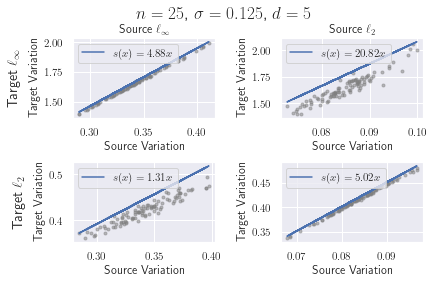

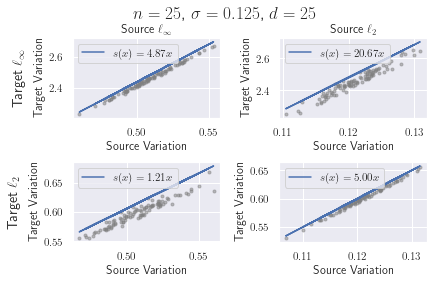

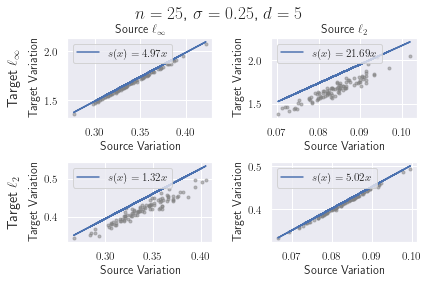

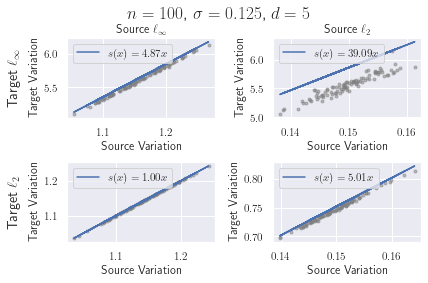

In [58]:
for d, sigma, n in params:
    data_all, _ = get_data(n, sigma)
    s_linf_linf, t_linf_linf, coef_linf = get_var_sources_targets(source_eps, target_eps, 'Linf', 'Linf', n, d, data_all, num_h=100)
    s_linf_l2, t_linf_l2, coef_linf_l2 = get_var_sources_targets(source_eps, target_eps, 'Linf', 'L2', n, d, data_all, num_h=100)
    s_l2_linf, t_l2_linf, coef_l2_linf = get_var_sources_targets(source_eps, target_eps, 'L2', 'Linf', n, d, data_all, num_h=100)
    s_l2_l2, t_l2_l2, coef_l2 = get_var_sources_targets(source_eps, target_eps, 'L2', 'L2', n, d, data_all, num_h=100)
    plot_exp(s_linf_linf, t_linf_linf, coef_linf,
            s_l2_linf, t_l2_linf, coef_l2_linf, 
            s_linf_l2, t_linf_l2, coef_linf_l2,
            s_l2_l2, t_l2_l2, coef_l2,
             n, sigma, d)

# Training with Linf

In [58]:
def get_errs_accs(d, sigma, n, data_all, labels_all, norm, var, source, targets, separate_test=False):
    accs_all_linf = []
    errs_all_linf = []
    accs_all_l2 = []
    errs_all_l2 = []
    for v in var:
        model = ToyNet(n, d).train()
        opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        train_varreg(model, source, opt, norm, data_all, labels_all, reg=v)
        
        model.eval()
        if separate_test:
            data_all, labels_all = get_data(n, sigma)
        
        errs_linf = np.array(val(model, targets, 'Linf', data_all, labels_all))
        errs_l2 = np.array(val(model, targets, 'L2', data_all, labels_all))
        if source == 'Linf':
            errs_l2 = errs_l2 - errs_linf[0]
            errs_linf = errs_linf - errs_linf[0]
        else:
            errs_linf = errs_linf - errs_l2[0]
            errs_l2 = errs_l2 - errs_l2[0]
        errs_all_linf.append(errs_linf)
        errs_all_l2.append(errs_l2)
        accs_all_linf.append(acc(model, targets, 'Linf', data_all, labels_all))
        accs_all_l2.append(acc(model, targets, 'L2', data_all, labels_all))
        
    return errs_all_linf, errs_all_l2, accs_all_linf, accs_all_l2
    

In [48]:
def plot_errs(targets, lambdas, a, b, source, d, sigma, n, col, acc=False, sep_test=False):
    fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
    pad = 5 # in points
    
    for i, l in enumerate(lambdas):
        if i == 0:
            color = 'k'
        else:
            color = col[-(len(lambdas) - i)]
        print(i)
        axes[0].plot(targets, a[i], label=r'$\lambda={}$'.format(l), color=color)
        axes[1].plot(targets, b[i], label=r'$\lambda={}$'.format(l), color=color)
        
    axes[0].set_xlabel(r'Target $\epsilon$')
    axes[0].set_title(r'Source ${}$ to Target $\ell_\infty$'.format(source))
    axes[1].set_xlabel(r'Target $\epsilon$')
    axes[1].set_title(r'Source ${}$ to Target $\ell_2$'.format(source))
    
    if acc:
        axes[1].set_ylabel(r'Accuracy (\%)')
        axes[0].set_ylabel(r'Accuracy (\%)')
    else:
        axes[1].set_ylabel(r'$L_T - L_S$')
        axes[0].set_ylabel(r'$L_T - L_S$')
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.03, 0.02), ncol=5)


    fig.tight_layout()
    fig.suptitle(r'$n = {}$, $\sigma = {}$, $d = {}$'.format(n**2, sigma, d), y=0.98, fontsize='x-large')
    
    fig.subplots_adjust(top=0.8, bottom=0.3)

    name='generalization'
    if acc:
        name='acc'
    if sep_test:
        name += '_sep_test'
        
    plt.savefig('gauss_{}_{}_{}_{}_source_{}.pdf'.format(name, d, sigma, n**2, source.split('_')[1].replace('\\', '')), bbox_inches="tight")
    plt.show()
    

0
1
2
3
4


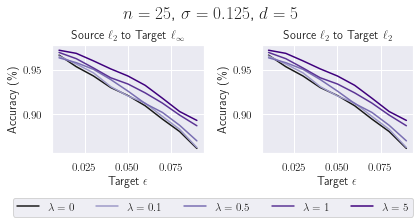

In [45]:
plot_errs(targets, lambdas, l2_linf_accs, l2_l2_accs, '\ell_2', 5, 0.125, 5, col, acc=True)

eps=0.01, test loss 0.07749819946289062
eps=0.02, test loss 0.096362060546875
eps=0.03, test loss 0.13545977783203125
eps=0.04, test loss 0.19853013610839843
eps=0.05, test loss 0.28386105346679685
eps=0.06, test loss 0.3985007019042969
eps=0.07, test loss 0.5565042724609375
eps=0.08, test loss 0.7509903564453125
eps=0.09, test loss 0.995785400390625
eps=0.01, test loss 0.07245842742919922
eps=0.02, test loss 0.0763997802734375
eps=0.03, test loss 0.08277989196777344
eps=0.04, test loss 0.091296875
eps=0.05, test loss 0.10593922424316406
eps=0.06, test loss 0.12299580383300782
eps=0.07, test loss 0.1473612823486328
eps=0.08, test loss 0.17546456909179686
eps=0.09, test loss 0.2084854736328125
eps=0.01, test acc 0.96
eps=0.02, test acc 0.94
eps=0.03, test acc 0.92
eps=0.04, test acc 0.89
eps=0.05, test acc 0.86
eps=0.06, test acc 0.82
eps=0.07, test acc 0.76
eps=0.08, test acc 0.71
eps=0.09, test acc 0.64
eps=0.01, test acc 0.97
eps=0.02, test acc 0.96
eps=0.03, test acc 0.95
eps=0.04, 

eps=0.07, test loss 0.40902850341796876
eps=0.08, test loss 0.5411603393554687
eps=0.09, test loss 0.7077178344726562
eps=0.01, test loss 0.0779822769165039
eps=0.02, test loss 0.08104013061523438
eps=0.03, test loss 0.08619976043701172
eps=0.04, test loss 0.09395962524414063
eps=0.05, test loss 0.10304900360107422
eps=0.06, test loss 0.11608100891113281
eps=0.07, test loss 0.137368896484375
eps=0.08, test loss 0.15895021057128905
eps=0.09, test loss 0.18340093994140624
eps=0.01, test acc 0.96
eps=0.02, test acc 0.94
eps=0.03, test acc 0.92
eps=0.04, test acc 0.90
eps=0.05, test acc 0.87
eps=0.06, test acc 0.83
eps=0.07, test acc 0.79
eps=0.08, test acc 0.74
eps=0.09, test acc 0.69
eps=0.01, test acc 0.96
eps=0.02, test acc 0.96
eps=0.03, test acc 0.95
eps=0.04, test acc 0.94
eps=0.05, test acc 0.94
eps=0.06, test acc 0.93
eps=0.07, test acc 0.91
eps=0.08, test acc 0.90
eps=0.09, test acc 0.89
eps=0.01, test loss 0.0950070571899414
eps=0.02, test loss 0.10822021484375
eps=0.03, test lo

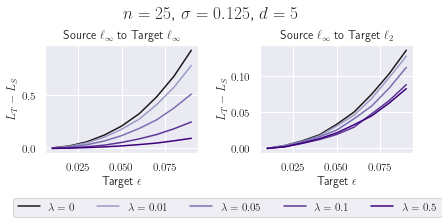

0
1
2
3
4


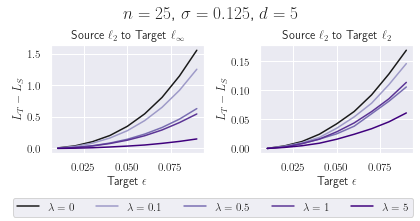

eps=0.01, test loss 0.07047116851806641
eps=0.02, test loss 0.09413983917236328
eps=0.03, test loss 0.14015049743652344
eps=0.04, test loss 0.20507586669921876
eps=0.05, test loss 0.3040205078125
eps=0.06, test loss 0.4427845153808594
eps=0.07, test loss 0.6253460693359375
eps=0.08, test loss 0.8581355590820312
eps=0.09, test loss 1.14722265625
eps=0.01, test loss 0.0656961669921875
eps=0.02, test loss 0.06897701263427734
eps=0.03, test loss 0.07534003448486327
eps=0.04, test loss 0.0873043212890625
eps=0.05, test loss 0.1011746826171875
eps=0.06, test loss 0.12253874206542968
eps=0.07, test loss 0.14716336059570312
eps=0.08, test loss 0.17629315185546876
eps=0.09, test loss 0.20944749450683595
eps=0.01, test acc 0.96
eps=0.02, test acc 0.94
eps=0.03, test acc 0.91
eps=0.04, test acc 0.89
eps=0.05, test acc 0.85
eps=0.06, test acc 0.79
eps=0.07, test acc 0.73
eps=0.08, test acc 0.66
eps=0.09, test acc 0.58
eps=0.01, test acc 0.97
eps=0.02, test acc 0.96
eps=0.03, test acc 0.96
eps=0.04

eps=0.07, test loss 0.5773146362304687
eps=0.08, test loss 0.777783447265625
eps=0.09, test loss 1.0217613525390625
eps=0.01, test loss 0.07808004760742188
eps=0.02, test loss 0.08171928405761719
eps=0.03, test loss 0.08738998413085937
eps=0.04, test loss 0.09583051300048828
eps=0.05, test loss 0.10795215606689453
eps=0.06, test loss 0.12469266510009766
eps=0.07, test loss 0.1447731170654297
eps=0.08, test loss 0.171829345703125
eps=0.09, test loss 0.20531411743164063
eps=0.01, test acc 0.95
eps=0.02, test acc 0.94
eps=0.03, test acc 0.91
eps=0.04, test acc 0.87
eps=0.05, test acc 0.83
eps=0.06, test acc 0.78
eps=0.07, test acc 0.72
eps=0.08, test acc 0.66
eps=0.09, test acc 0.59
eps=0.01, test acc 0.96
eps=0.02, test acc 0.95
eps=0.03, test acc 0.95
eps=0.04, test acc 0.94
eps=0.05, test acc 0.93
eps=0.06, test acc 0.92
eps=0.07, test acc 0.91
eps=0.08, test acc 0.89
eps=0.09, test acc 0.87
eps=0.01, test loss 0.09431459045410157
eps=0.02, test loss 0.10986253356933594
eps=0.03, test 

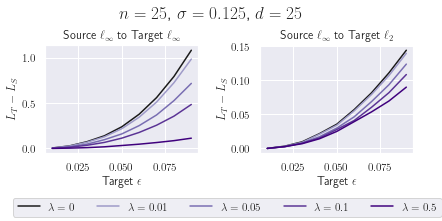

0
1
2
3
4


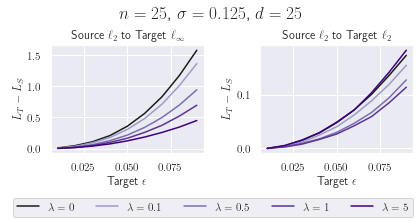

eps=0.01, test loss 0.3564705200195312
eps=0.02, test loss 0.36175518798828127
eps=0.03, test loss 0.3705726623535156
eps=0.04, test loss 0.3820487060546875
eps=0.05, test loss 0.39876580810546874
eps=0.06, test loss 0.42070751953125
eps=0.07, test loss 0.4462598876953125
eps=0.08, test loss 0.477983642578125
eps=0.09, test loss 0.515036376953125
eps=0.01, test loss 0.35565206909179686
eps=0.02, test loss 0.35677288818359376
eps=0.03, test loss 0.3596803283691406
eps=0.04, test loss 0.3629251403808594
eps=0.05, test loss 0.368252197265625
eps=0.06, test loss 0.37367095947265627
eps=0.07, test loss 0.38030914306640623
eps=0.08, test loss 0.3882567749023437
eps=0.09, test loss 0.39745669555664065
eps=0.01, test acc 0.84
eps=0.02, test acc 0.81
eps=0.03, test acc 0.79
eps=0.04, test acc 0.77
eps=0.05, test acc 0.74
eps=0.06, test acc 0.71
eps=0.07, test acc 0.68
eps=0.08, test acc 0.65
eps=0.09, test acc 0.61
eps=0.01, test acc 0.84
eps=0.02, test acc 0.83
eps=0.03, test acc 0.82
eps=0.04

eps=0.07, test loss 0.4406368103027344
eps=0.08, test loss 0.4672422485351562
eps=0.09, test loss 0.49926617431640624
eps=0.01, test loss 0.36196160888671874
eps=0.02, test loss 0.3631687927246094
eps=0.03, test loss 0.3650327453613281
eps=0.04, test loss 0.3684661254882812
eps=0.05, test loss 0.37189315795898437
eps=0.06, test loss 0.37668255615234375
eps=0.07, test loss 0.38369757080078126
eps=0.08, test loss 0.391104248046875
eps=0.09, test loss 0.40037396240234374
eps=0.01, test acc 0.82
eps=0.02, test acc 0.81
eps=0.03, test acc 0.79
eps=0.04, test acc 0.76
eps=0.05, test acc 0.74
eps=0.06, test acc 0.71
eps=0.07, test acc 0.68
eps=0.08, test acc 0.66
eps=0.09, test acc 0.63
eps=0.01, test acc 0.83
eps=0.02, test acc 0.82
eps=0.03, test acc 0.81
eps=0.04, test acc 0.80
eps=0.05, test acc 0.79
eps=0.06, test acc 0.78
eps=0.07, test acc 0.76
eps=0.08, test acc 0.75
eps=0.09, test acc 0.74
eps=0.01, test loss 0.37518026733398435
eps=0.02, test loss 0.3791250305175781
eps=0.03, test l

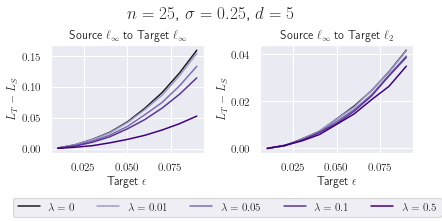

0
1
2
3
4


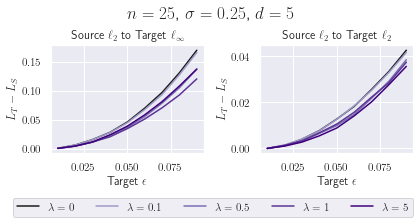

eps=0.01, test loss 0.09188700866699219
eps=0.02, test loss 0.2173026123046875
eps=0.03, test loss 0.4833364562988281
eps=0.04, test loss 0.9136668090820312
eps=0.05, test loss 1.539619140625
eps=0.06, test loss 2.364517333984375
eps=0.07, test loss 3.387306640625
eps=0.08, test loss 4.59494921875
eps=0.09, test loss 5.9623486328125
eps=0.01, test loss 0.06434220886230468
eps=0.02, test loss 0.06996945953369141
eps=0.03, test loss 0.08138174438476563
eps=0.04, test loss 0.09984957122802735
eps=0.05, test loss 0.12598081970214844
eps=0.06, test loss 0.15911895751953126
eps=0.07, test loss 0.20291648864746092
eps=0.08, test loss 0.26012051391601565
eps=0.09, test loss 0.3258634338378906
eps=0.01, test acc 0.95
eps=0.02, test acc 0.90
eps=0.03, test acc 0.81
eps=0.04, test acc 0.72
eps=0.05, test acc 0.61
eps=0.06, test acc 0.49
eps=0.07, test acc 0.38
eps=0.08, test acc 0.27
eps=0.09, test acc 0.18
eps=0.01, test acc 0.98
eps=0.02, test acc 0.97
eps=0.03, test acc 0.96
eps=0.04, test acc

eps=0.09, test loss 13.3527275390625
eps=0.01, test loss 0.06117587661743164
eps=0.02, test loss 0.06509638977050781
eps=0.03, test loss 0.07791334533691406
eps=0.04, test loss 0.09853349304199219
eps=0.05, test loss 0.12608576202392577
eps=0.06, test loss 0.163318603515625
eps=0.07, test loss 0.2171209716796875
eps=0.08, test loss 0.2825531311035156
eps=0.09, test loss 0.35885986328125
eps=0.01, test acc 0.93
eps=0.02, test acc 0.82
eps=0.03, test acc 0.68
eps=0.04, test acc 0.51
eps=0.05, test acc 0.35
eps=0.06, test acc 0.21
eps=0.07, test acc 0.10
eps=0.08, test acc 0.04
eps=0.09, test acc 0.01
eps=0.01, test acc 0.98
eps=0.02, test acc 0.97
eps=0.03, test acc 0.96
eps=0.04, test acc 0.95
eps=0.05, test acc 0.93
eps=0.06, test acc 0.92
eps=0.07, test acc 0.89
eps=0.08, test acc 0.87
eps=0.09, test acc 0.85
eps=0.01, test loss 0.09477461242675782
eps=0.02, test loss 0.29277767944335936
eps=0.03, test loss 0.7256866455078125
eps=0.04, test loss 1.434626220703125
eps=0.05, test loss 2

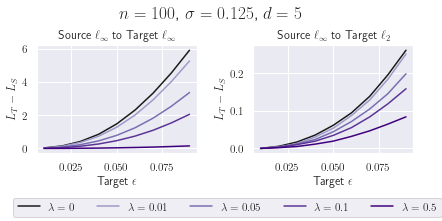

0
1
2
3
4


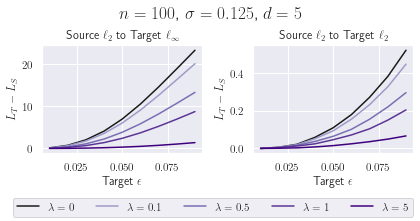

In [63]:
lambdas = [0, 0.1, 0.5, 1, 5]
lambdas_linf = [0, 0.01, 0.05, 0.1, 0.5]
targets = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
source_eps = 0.01
col = plt.cm.Purples(np.linspace(0, 1, len(lambdas)+2))


all_res = {}

for d, sigma, n in params:
    data_all, labels_all = get_data(n, sigma)
    linf_linf_errs, linf_l2_errs, linf_linf_accs, linf_l2_accs = get_errs_accs(d, sigma, n, data_all, labels_all, 'Linf', lambdas_linf, source_eps, targets)
    l2_linf_errs, l2_l2_errs, l2_linf_accs, l2_linf_accs = get_errs_accs(d, sigma, n, data_all, labels_all, 'L2', lambdas, source_eps, targets)
    all_res[(d, sigma, n)] = (linf_linf_errs, linf_l2_errs, linf_linf_accs,
                              linf_l2_accs, l2_linf_errs, l2_l2_errs, l2_linf_accs, l2_l2_accs)
    plot_errs(targets, lambdas_linf, linf_linf_errs, linf_l2_errs, '\ell_\infty', d, sigma, n, col)
    plot_errs(targets, lambdas,  l2_linf_errs, l2_l2_errs, '\ell_2', d, sigma, n, col)

In [81]:

targets = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
source_eps = 0.01

d, sigma, n = (5, 0.125, 10)
data_all, labels_all = get_data(n, sigma)
#linf_linf_errs, linf_l2_errs, linf_linf_accs, linf_l2_accs = get_errs_accs(d, sigma, n, data_all, labels_all, 'Linf', lambdas, source_eps, targets)
l2_linf_errs, l2_l2_errs, l2_linf_accs, l2_linf_accs = get_errs_accs(d, sigma, n, data_all, labels_all, 'L2', lambdas, source_eps, targets)

eps=0.01, test loss 0.19964715576171874
eps=0.02, test loss 0.7331527099609375
eps=0.03, test loss 1.9403958740234375
eps=0.04, test loss 3.96612451171875
eps=0.05, test loss 6.76047705078125
eps=0.06, test loss 10.242935546875
eps=0.07, test loss 14.2307958984375
eps=0.08, test loss 18.49850390625
eps=0.09, test loss 22.8680234375
eps=0.01, test loss 0.08127095031738281
eps=0.02, test loss 0.08797161865234375
eps=0.03, test loss 0.10766651916503907
eps=0.04, test loss 0.14597698974609374
eps=0.05, test loss 0.19653065490722657
eps=0.06, test loss 0.2656501159667969
eps=0.07, test loss 0.3498867492675781
eps=0.08, test loss 0.45792596435546873
eps=0.09, test loss 0.5826859741210938
eps=0.01, test acc 0.93
eps=0.02, test acc 0.83
eps=0.03, test acc 0.67
eps=0.04, test acc 0.49
eps=0.05, test acc 0.33
eps=0.06, test acc 0.19
eps=0.07, test acc 0.09
eps=0.08, test acc 0.04
eps=0.09, test acc 0.01
eps=0.01, test acc 0.98
eps=0.02, test acc 0.97
eps=0.03, test acc 0.96
eps=0.04, test acc 0.

In [50]:
d, sigma, n = (5, 0.125, 5)
data_all, labels_all = get_data(n, sigma)
linf_linf_errs, linf_l2_errs, _, _ = get_errs_accs(d, sigma, n, data_all, labels_all, 'Linf', lambdas_linf, source_eps, targets, separate_test=True )


eps=0.01, test loss 0.08634993743896484
eps=0.02, test loss 0.11271176147460937
eps=0.03, test loss 0.15922547912597657
eps=0.04, test loss 0.23614668273925782
eps=0.05, test loss 0.34348037719726565
eps=0.06, test loss 0.5018475036621094
eps=0.07, test loss 0.699833984375
eps=0.08, test loss 0.957914306640625
eps=0.09, test loss 1.2597755126953125
eps=0.01, test loss 0.07955574035644532
eps=0.02, test loss 0.08429293823242187
eps=0.03, test loss 0.09158544921875
eps=0.04, test loss 0.10390560150146484
eps=0.05, test loss 0.12022277069091797
eps=0.06, test loss 0.1366268615722656
eps=0.07, test loss 0.1631405029296875
eps=0.08, test loss 0.19572906494140624
eps=0.09, test loss 0.23224050903320312
eps=0.01, test loss 0.08579166412353516
eps=0.02, test loss 0.1045707778930664
eps=0.03, test loss 0.1345238494873047
eps=0.04, test loss 0.18335076904296874
eps=0.05, test loss 0.25632073974609376
eps=0.06, test loss 0.34438250732421877
eps=0.07, test loss 0.4716932678222656
eps=0.08, test lo

0
1
2
3
4


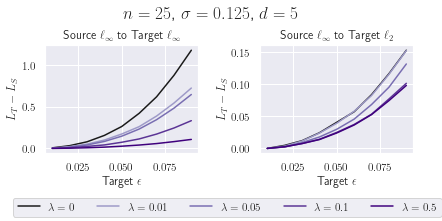

In [51]:
plot_errs(targets, lambdas_linf, linf_linf_errs, linf_l2_errs, '\ell_\infty', d, sigma, n, col, sep_test=True)

In [61]:
l2_linf_errs, l2_l2_errs, _, _ = get_errs_accs(d, sigma, n, data_all, labels_all, 'L2', lambdas, source_eps, targets, separate_test=True)


eps=0.01, test loss 0.09697660827636718
eps=0.02, test loss 0.13125532531738282
eps=0.03, test loss 0.2011143798828125
eps=0.04, test loss 0.3096314392089844
eps=0.05, test loss 0.46845770263671876
eps=0.06, test loss 0.6914781494140625
eps=0.07, test loss 0.991775146484375
eps=0.08, test loss 1.3608101806640625
eps=0.09, test loss 1.7957926025390625
eps=0.01, test loss 0.08748246765136719
eps=0.02, test loss 0.09232545471191406
eps=0.03, test loss 0.10152691650390624
eps=0.04, test loss 0.11324617004394531
eps=0.05, test loss 0.1305967254638672
eps=0.06, test loss 0.15558636474609375
eps=0.07, test loss 0.18438119506835937
eps=0.08, test loss 0.22232975769042967
eps=0.09, test loss 0.26905084228515624
eps=0.01, test acc 0.95
eps=0.02, test acc 0.93
eps=0.03, test acc 0.89
eps=0.04, test acc 0.85
eps=0.05, test acc 0.80
eps=0.06, test acc 0.74
eps=0.07, test acc 0.66
eps=0.08, test acc 0.59
eps=0.09, test acc 0.53
eps=0.01, test acc 0.96
eps=0.02, test acc 0.95
eps=0.03, test acc 0.94


0
1
2
3
4


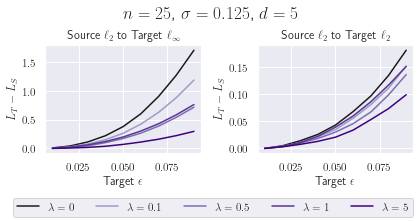

In [62]:
plot_errs(targets, lambdas, l2_linf_errs, l2_l2_errs, '\ell_2', d, sigma, n, col, sep_test=True)

In [59]:
_, _, l2_linf_accs, l2_l2_accs = get_errs_accs(d, sigma, n, data_all, labels_all, 'L2', lambdas, source_eps, targets)


eps=0.01, test loss 0.07961580657958985
eps=0.02, test loss 0.11797392272949218
eps=0.03, test loss 0.18612652587890624
eps=0.04, test loss 0.2958602600097656
eps=0.05, test loss 0.4607958068847656
eps=0.06, test loss 0.676686279296875
eps=0.07, test loss 0.973234375
eps=0.08, test loss 1.3385015869140624
eps=0.09, test loss 1.7883638916015625
eps=0.01, test loss 0.07222980499267578
eps=0.02, test loss 0.07625434875488281
eps=0.03, test loss 0.08420880889892578
eps=0.04, test loss 0.0979520492553711
eps=0.05, test loss 0.1189477767944336
eps=0.06, test loss 0.14364781188964842
eps=0.07, test loss 0.17163539123535157
eps=0.08, test loss 0.20904249572753905
eps=0.09, test loss 0.2521654052734375
eps=0.01, test acc 0.96
eps=0.02, test acc 0.93
eps=0.03, test acc 0.90
eps=0.04, test acc 0.86
eps=0.05, test acc 0.81
eps=0.06, test acc 0.75
eps=0.07, test acc 0.67
eps=0.08, test acc 0.60
eps=0.09, test acc 0.52
eps=0.01, test acc 0.97
eps=0.02, test acc 0.96
eps=0.03, test acc 0.95
eps=0.04,

0
1
2
3
4


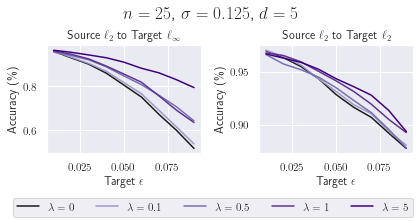

In [60]:
plot_errs(targets, lambdas, l2_linf_accs, l2_l2_accs, '\ell_2', d, sigma, n, col, acc=True)